In this notebook we will apply Strategy 2 for transfer learning. When using this strategy we train some layers while leaving other layers frozen.

This technique is indicated in two cases:

1. **Large dataset and similar to the pre-trained model dataset:** Since the dataset is large  overfitting shouldn’t be an issue, so we can learn as much as we want. However, since the datasets are similar, we can save ourselves from a huge training effort by leveraging previous knowledge. Therefore, it should be enough to train the classifier and the top layers of the convolutional base.

2. **Small dataset and similar to the pre-trained model dataset:** In this case is a challenge to find a balance between the number of layers to train and freeze.  This because on one side, if you go to deep you risk overfitting while on the other side, if not the model will not learn enough. Data augmentation is a technique that should be considered in order to fight overfitting and allow the model to learn enough.

This method is known as `Fine-tuning`. `Fine-tuning` is widely used technique for model reuse and complementary to feature extraction. 

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (the classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In addition, because our dataset is small we will make use of data augmentation.

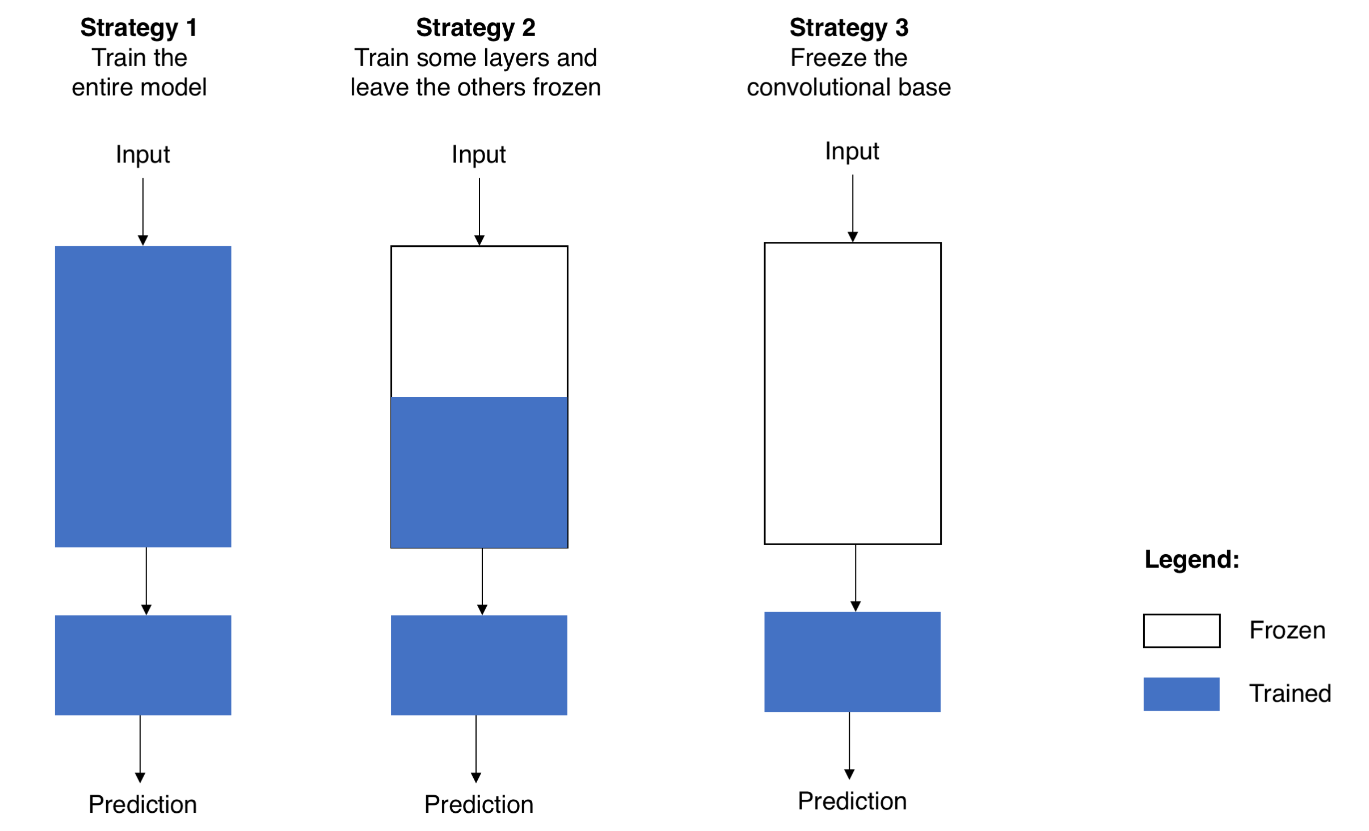

In [1]:
from IPython.display import Image
Image("strategies.png")

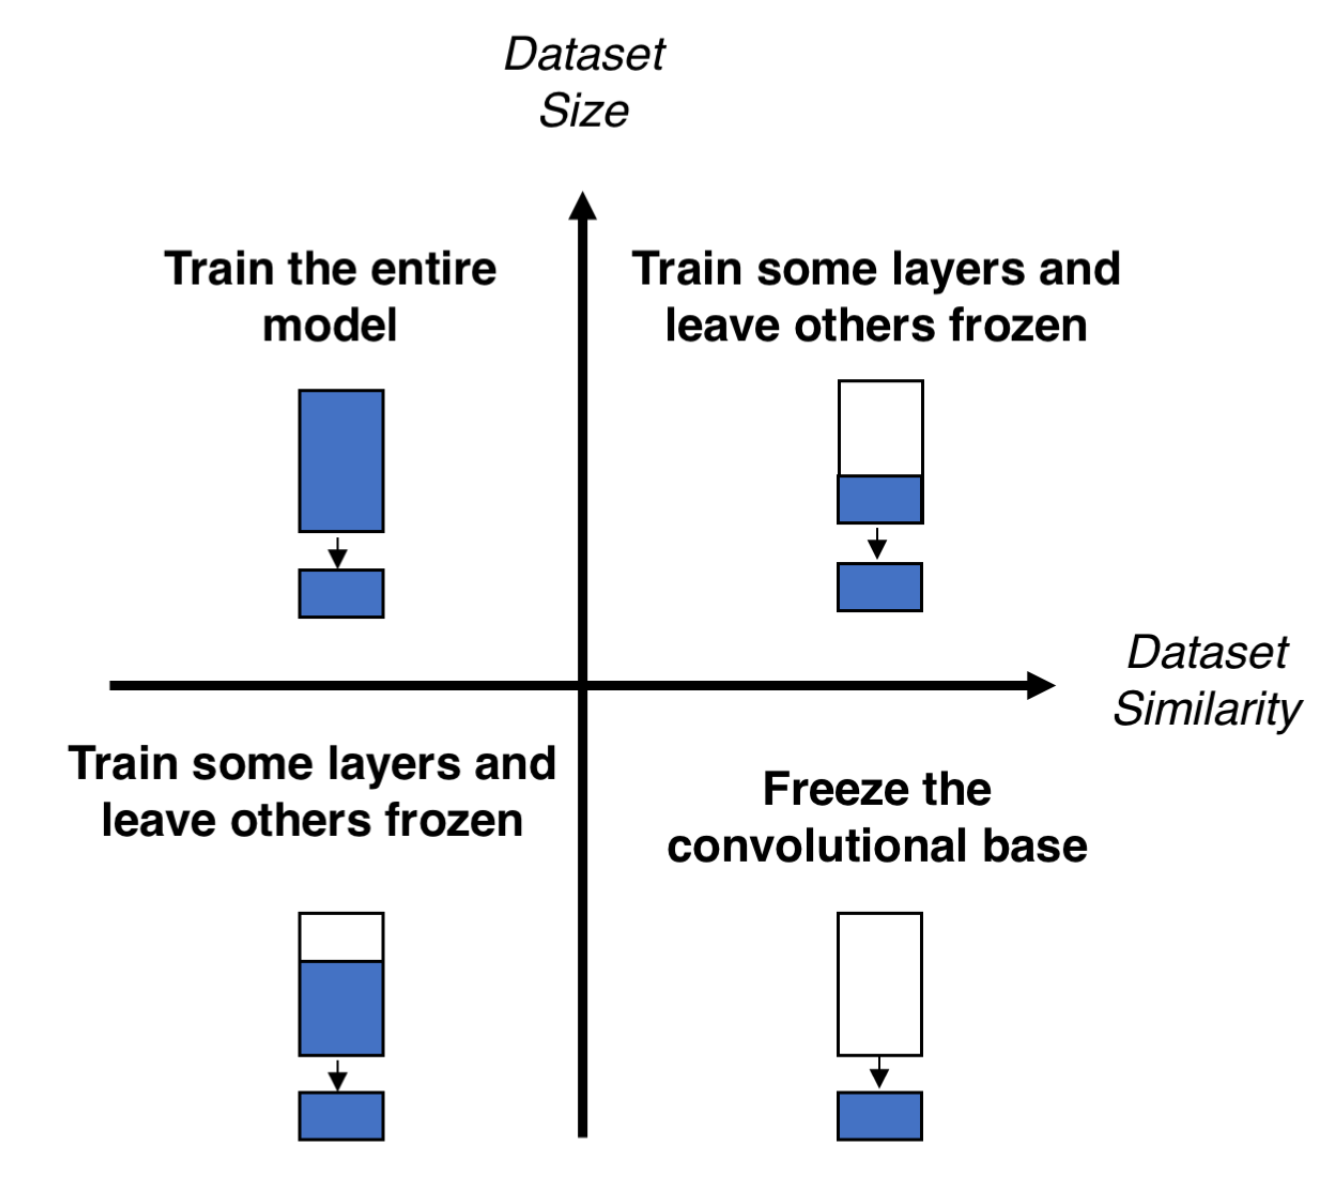

In [2]:
from IPython.display import Image
Image("approaches.png")

It is necessary to freeze the convolution base of the pre-trained network in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already be trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

**Step1** Add your custom network on top of an already trained base network.

**Step2** Freeze the base network.

**Step3** Train the part you added (Classifier).

**Step4** Unfreeze some layers in the base network.

**Step5** Jointly train both these layers and the part you added.

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for MobileNetV2 is 224,224

In [4]:
# Instantiate convolutional base

from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_channels))

Using TensorFlow backend.


In [5]:
conv_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [6]:
conv_base.input_shape

(None, 128, 128, 3)

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5243136   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 7,501,377
Trainable params: 7,467,265
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 160


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 mobilenetv2_1.00_128 False
1 flatten_1 True
2 dense_1 True
3 dropout_1 True
4 dense_2 True


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 Conv1_pad True
2 Conv1 True
3 bn_Conv1 True
4 Conv1_relu True
5 expanded_conv_depthwise True
6 expanded_conv_depthwise_BN True
7 expanded_conv_depthwise_relu True
8 expanded_conv_project True
9 expanded_conv_project_BN True
10 block_1_expand True
11 block_1_expand_BN True
12 block_1_expand_relu True
13 block_1_pad True
14 block_1_depthwise True
15 block_1_depthwise_BN True
16 block_1_depthwise_relu True
17 block_1_project True
18 block_1_project_BN True
19 block_2_expand True
20 block_2_expand_BN True
21 block_2_expand_relu True
22 block_2_depthwise True
23 block_2_depthwise_BN True
24 block_2_depthwise_relu True
25 block_2_project True
26 block_2_project_BN True
27 block_2_add True
28 block_3_expand True
29 block_3_expand_BN True
30 block_3_expand_relu True
31 block_3_pad True
32 block_3_depthwise True
33 block_3_depthwise_BN True
34 block_3_depthwise_relu True
35 block_3_project True
36 block_3_project_BN True
37 block_4_expand True
38 block_4_expand_BN True
39 bloc

In [15]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,Conv1_pad,True
2,Conv1,True
3,bn_Conv1,True
4,Conv1_relu,True
5,expanded_conv_depthwise,True
6,expanded_conv_depthwise_BN,True
7,expanded_conv_depthwise_relu,True
8,expanded_conv_project,True
9,expanded_conv_project_BN,True


In [16]:
conv_base.trainable = True

for layer in conv_base.layers[:144]:
    layer.trainable = False

In [17]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,Conv1_pad,False
2,Conv1,False
3,bn_Conv1,False
4,Conv1_relu,False
5,expanded_conv_depthwise,False
6,expanded_conv_depthwise_BN,False
7,expanded_conv_depthwise_relu,False
8,expanded_conv_project,False
9,expanded_conv_project_BN,False


In [18]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [19]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-27 20:51:34.210724


In [20]:
# Train model

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 142s 1s/step - loss: 0.8196 - acc: 0.6815 - val_loss: 0.5461 - val_acc: 0.7621
Epoch 2/30
100/100 [==============================] - 145s 1s/step - loss: 0.7059 - acc: 0.7145 - val_loss: 0.5260 - val_acc: 0.7449
Epoch 3/30
100/100 [==============================] - 140s 1s/step - loss: 0.6748 - acc: 0.7082 - val_loss: 0.3454 - val_acc: 0.7560
Epoch 4/30
100/100 [==============================] - 144s 1s/step - loss: 0.6288 - acc: 0.7183 - val_loss: 0.2986 - val_acc: 0.7652
Epoch 5/30
100/100 [==============================] - 139s 1s/step - loss: 0.6259 - acc: 0.7460 - val_loss: 0.7143 - val_acc: 0.7702
Epoch 6/30
100/100 [==============================] - 146s 1s/step - loss: 0.5685 - acc: 0.7545 - val_loss: 0.4189 - val_acc: 0.7490
Epoch 7/30
100/100 [==============================] - 139s 1s/step - loss: 0.5706 - acc: 0.7466 - val_loss: 0.4786 - val_acc: 0.7661


## Save model

In [21]:
model.save("../models/MobileNetV2_firebreak_detection_fine_tuning_FC_model.h5")

## Model evaluation

### Learning curves

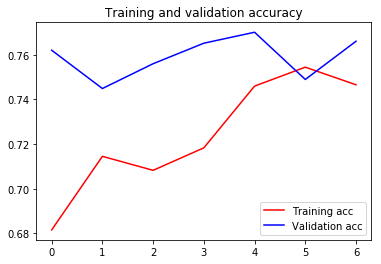

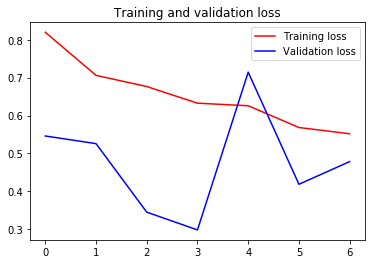

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/MobileNetV2_firebreak_detection_fine_tuning_FC_history.csv", index = False)

In [24]:
t2 = datetime.datetime.now()
print(t2)
print(t2-t1)

2019-11-27 21:08:14.534883
0:16:40.324159


### Model in action

In [25]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [26]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)
results.head()

32/32 [==============================] - 29s 921ms/step


,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.093710,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.060135,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.040472,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.173724,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.101296,0.0


In [27]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

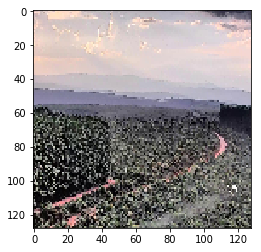

2018-03-16 17-30-18_NAO.jpeg
Not firebreack


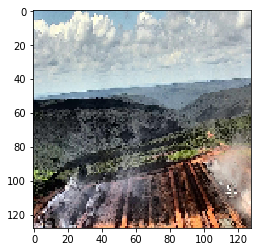

2018-03-18 10-42-59_NAO.jpeg
Not firebreack


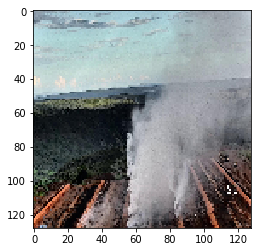

2018-03-13 16-53-14_SIM.jpeg
Not firebreack


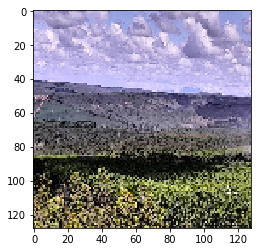

2018-03-12 13-26-39_NAO.jpeg
Not firebreack


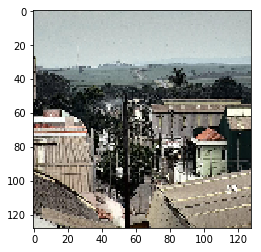

2018-01-10 12-03-50_SIM.jpeg
Not firebreack


In [28]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [30]:
# Instantiate convolutional base

from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [31]:
# Define model

from keras import models
from keras import layers

#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [32]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [33]:
conv_base.trainable = False

In [34]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [35]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mobilenetv2_1.00_128
1 global_average_pooling2d_1
2 dense_3


## Compile model

In [36]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 Conv1_pad True
2 Conv1 True
3 bn_Conv1 True
4 Conv1_relu True
5 expanded_conv_depthwise True
6 expanded_conv_depthwise_BN True
7 expanded_conv_depthwise_relu True
8 expanded_conv_project True
9 expanded_conv_project_BN True
10 block_1_expand True
11 block_1_expand_BN True
12 block_1_expand_relu True
13 block_1_pad True
14 block_1_depthwise True
15 block_1_depthwise_BN True
16 block_1_depthwise_relu True
17 block_1_project True
18 block_1_project_BN True
19 block_2_expand True
20 block_2_expand_BN True
21 block_2_expand_relu True
22 block_2_depthwise True
23 block_2_depthwise_BN True
24 block_2_depthwise_relu True
25 block_2_project True
26 block_2_project_BN True
27 block_2_add True
28 block_3_expand True
29 block_3_expand_BN True
30 block_3_expand_relu True
31 block_3_pad True
32 block_3_depthwise True
33 block_3_depthwise_BN True
34 block_3_depthwise_relu True
35 block_3_project True
36 block_3_project_BN True
37 block_4_expand True
38 block_4_expand_BN True
39 bloc

In [37]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,Conv1_pad,True
2,Conv1,True
3,bn_Conv1,True
4,Conv1_relu,True
5,expanded_conv_depthwise,True
6,expanded_conv_depthwise_BN,True
7,expanded_conv_depthwise_relu,True
8,expanded_conv_project,True
9,expanded_conv_project_BN,True


In [38]:
conv_base.trainable = True

for layer in conv_base.layers[:144]:
    layer.trainable = False

In [39]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,Conv1_pad,False
2,Conv1,False
3,bn_Conv1,False
4,Conv1_relu,False
5,expanded_conv_depthwise,False
6,expanded_conv_depthwise_BN,False
7,expanded_conv_depthwise_relu,False
8,expanded_conv_project,False
9,expanded_conv_project_BN,False


In [40]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [41]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 136s 1s/step - loss: 0.6816 - acc: 0.5952 - val_loss: 0.6867 - val_acc: 0.7046
Epoch 2/30
100/100 [==============================] - 139s 1s/step - loss: 0.6005 - acc: 0.6925 - val_loss: 0.6206 - val_acc: 0.7195
Epoch 3/30
100/100 [==============================] - 136s 1s/step - loss: 0.5615 - acc: 0.7255 - val_loss: 0.4441 - val_acc: 0.7359
Epoch 4/30
100/100 [==============================] - 139s 1s/step - loss: 0.5397 - acc: 0.7465 - val_loss: 0.4992 - val_acc: 0.7419
Epoch 5/30
100/100 [==============================] - 137s 1s/step - loss: 0.5111 - acc: 0.7713 - val_loss: 0.6439 - val_acc: 0.7389
Epoch 6/30
100/100 [==============================] - 138s 1s/step - loss: 0.5059 - acc: 0.7700 - val_loss: 0.7934 - val_acc: 0.7297


## Save model

In [42]:
model.save("../models/MobileNetV2_firebreak_detection_fine_tuning_GAP_model.h5")

# Model evaluation

## Learning curves

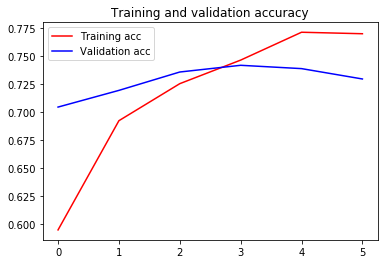

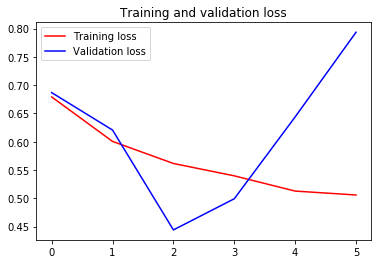

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/MobileNetV2_firebreak_detection_fine_tuning_GAP_history.csv", index = False)

In [45]:
t3 = datetime.datetime.now()
print(t3)
print(t3-t2)

2019-11-27 22:51:58.864096
1:43:44.329213


## Model in action

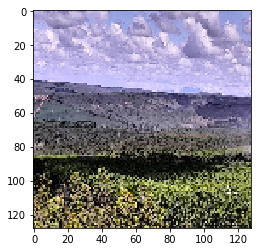

2018-03-12 13-26-39_NAO.jpeg
Not firebreack


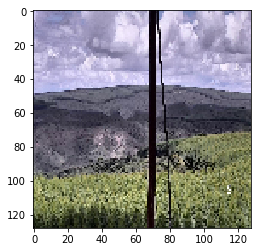

2018-03-12 11-38-27_NAO.jpeg
Not firebreack


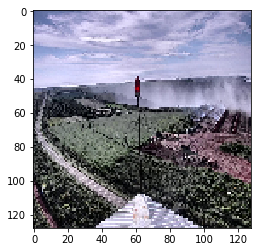

2018-03-06 07-32-14_SIM.jpeg
Not firebreack


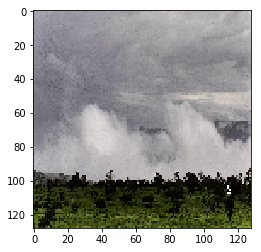

2018-03-12 08-11-27_NAO.jpeg
Not firebreack


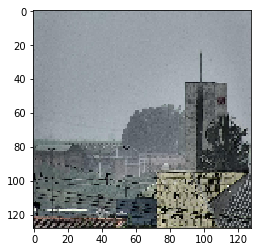

2018-01-30 08-53-00_NAO.jpeg
Not firebreack


In [46]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks